In [1]:
import pickle

def load_and_preview_features(file_path, dataset_name, print_limit=5):
    """
    加载并预览特征数据，只打印正负中性标签的前若干条。
    返回所有数据（未截断）。
    """
    with open(file_path, 'rb') as file:
        features = pickle.load(file)

    print(f"\n--- {dataset_name.upper()} DATASET ---")

    count = 0
    for i, item in enumerate(features):
        label = item.get('label', 'N/A')
        if label not in ['Positive', 'Negative', 'Neutral']:
            continue

        if count < print_limit:
            video_id = item.get('video_id', 'N/A')
            clip_id = item.get('clip_id', 'N/A')
            label_1 = item.get('label_1', 'N/A')
            mode = item.get('mode', 'N/A')
            text = item.get('text', 'N/A')
            text_feature_shape = item['text_feature'].shape if 'text_feature' in item else 'N/A'
            audio_feature_shape = item['audio_feature'].shape if 'audio_feature' in item else 'N/A'
            #vision_feature_shape = item['vision_features'].shape if 'vision_features' in item else 'N/A'
            #vision_feature_shape1 = item['vision_feature_resnet'].shape if 'vision_feature_resnet' in item else 'N/A'

            print(f"Item {i}:")
            print(f"  video_id: {video_id}")
            print(f"  clip_id: {clip_id}")
            print(f"  label_1: {label_1}")
            print(f"  label: {label}")
            print(f"  mode: {mode}")
            print(f"  text: {text}")
            print(f"  text_feature_shape: {text_feature_shape}")
            print(f"  audio_feature_shape: {audio_feature_shape}")
            #print(f"  vision_feature_shape (DenseNet): {vision_feature_shape}")
            #print(f"  vision_feature_shape (ResNet): {vision_feature_shape1}")
            print("-" * 50)
            count += 1

    print(f"共加载样本数: {len(features)}（其中三类标签样本展示前 {print_limit} 条）")
    return features

In [2]:
train_features = load_and_preview_features('/root/autodl-tmp/train_features.pkl', 'train')
valid_features = load_and_preview_features('/root/autodl-tmp/valid_features.pkl', 'valid')
test_features = load_and_preview_features('/root/autodl-tmp/test_features.pkl', 'test')


--- TRAIN DATASET ---
Item 0:
  video_id: -3g5yACwYnA
  clip_id: 10
  label_1: 1.0
  label: Positive
  mode: train
  text: N/A
  text_feature_shape: (1, 50, 768)
  audio_feature_shape: torch.Size([1, 1284, 1024])
--------------------------------------------------
Item 1:
  video_id: -3g5yACwYnA
  clip_id: 13
  label_1: 0.6666666865348816
  label: Positive
  mode: train
  text: N/A
  text_feature_shape: (1, 19, 768)
  audio_feature_shape: torch.Size([1, 438, 1024])
--------------------------------------------------
Item 2:
  video_id: -3g5yACwYnA
  clip_id: 3
  label_1: 0.0
  label: Neutral
  mode: train
  text: N/A
  text_feature_shape: (1, 40, 768)
  audio_feature_shape: torch.Size([1, 963, 1024])
--------------------------------------------------
Item 3:
  video_id: -3g5yACwYnA
  clip_id: 2
  label_1: 0.0
  label: Neutral
  mode: train
  text: N/A
  text_feature_shape: (1, 19, 768)
  audio_feature_shape: torch.Size([1, 711, 1024])
--------------------------------------------------
I

In [3]:
import numpy as np
import torch
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

# 假设 features 已经加载并包含在内
train_data = [item for item in train_features if item['mode'] == 'train']
valid_data = [item for item in valid_features if item['mode'] == 'valid']
test_data = [item for item in test_features if item['mode'] == 'test']

In [4]:
del train_features, valid_features,test_features

In [5]:
train_X_text = [item['text_feature'] for item in train_data]
valid_X_text = [item['text_feature'] for item in valid_data]
test_X_text = [item['text_feature'] for item in test_data]

train_X_audio = [item['audio_feature'] for item in train_data]
valid_X_audio = [item['audio_feature'] for item in valid_data]
test_X_audio = [item['audio_feature'] for item in test_data]

train_X_vision = [item['vision_feature_resnet'] for item in train_data]
valid_X_vision = [item['vision_feature_resnet'] for item in valid_data]
test_X_vision = [item['vision_feature_resnet'] for item in test_data]

In [6]:
import numpy as np

# 连续目标：直接用 label_1（确保是 float）
train_Y = np.array([float(item['label_1']) for item in train_data], dtype=np.float32)
valid_Y = np.array([float(item['label_1']) for item in valid_data], dtype=np.float32)
test_Y  = np.array([float(item['label_1']) for item in test_data],  dtype=np.float32)

# 小检查（可选）
print(train_Y[:10], train_Y.min(), train_Y.max())  # 例如应在 [-3, 3] 区间


[ 1.          0.6666667   0.          0.          1.          0.6666667
  0.33333334  1.          0.         -0.6666667 ] -3.0 3.0


In [7]:
import numpy as np
import torch

def _to_2d_float_tensor(x):
    # x 可能是 np.ndarray 或 torch.Tensor，形状 [1, T, D] or [T, D]
    if isinstance(x, np.ndarray):
        t = torch.as_tensor(x)
    else:
        t = x  # 已经是 tensor
    # 去掉可能存在的前导 1 维，使之变成 [T, D]
    if t.dim() == 3 and t.size(0) == 1:
        t = t.squeeze(0)
    return t.to(torch.float32).contiguous()

# 处理 audio
audio_feats = {
    'train': train_X_audio,
    'valid': valid_X_audio,
    'test' : test_X_audio,
}
for split, lst in audio_feats.items():
    for i, feat in enumerate(lst):
        lst[i] = _to_2d_float_tensor(feat)
        print(f'audio {split}[{i}] -> {lst[i].shape}')  # 可选检查

# 处理 text
text_feats = {
    'train': train_X_text,
    'valid': valid_X_text,
    'test' : test_X_text,
}
for split, lst in text_feats.items():
    for i, feat in enumerate(lst):
        lst[i] = _to_2d_float_tensor(feat)
        print(f'text {split}[{i}] -> {lst[i].shape}')  # 可选检查


audio train[0] -> torch.Size([1284, 1024])
audio train[1] -> torch.Size([438, 1024])
audio train[2] -> torch.Size([963, 1024])
audio train[3] -> torch.Size([711, 1024])
audio train[4] -> torch.Size([821, 1024])
audio train[5] -> torch.Size([811, 1024])
audio train[6] -> torch.Size([464, 1024])
audio train[7] -> torch.Size([591, 1024])
audio train[8] -> torch.Size([546, 1024])
audio train[9] -> torch.Size([573, 1024])
audio train[10] -> torch.Size([121, 1024])
audio train[11] -> torch.Size([366, 1024])
audio train[12] -> torch.Size([407, 1024])
audio train[13] -> torch.Size([573, 1024])
audio train[14] -> torch.Size([668, 1024])
audio train[15] -> torch.Size([433, 1024])
audio train[16] -> torch.Size([338, 1024])
audio train[17] -> torch.Size([571, 1024])
audio train[18] -> torch.Size([458, 1024])
audio train[19] -> torch.Size([455, 1024])
audio train[20] -> torch.Size([719, 1024])
audio train[21] -> torch.Size([487, 1024])
audio train[22] -> torch.Size([207, 1024])
audio train[23] -> t

In [8]:
from torch.utils.data import Dataset, DataLoader
import torch
from torch.nn.utils.rnn import pad_sequence

class TwoModalRegressionDataset(Dataset):
    def __init__(self, text_features, audio_features, labels):
        assert len(text_features) == len(audio_features) == len(labels)
        self.text_features = text_features
        self.audio_features = audio_features
        self.labels = labels  # 连续标签（list/np/tensor均可）

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # 保证是 [T, D] 的 2D tensor，并转为 float32
        text  = torch.as_tensor(self.text_features[idx]).squeeze(0).to(torch.float32)
        audio = torch.as_tensor(self.audio_features[idx]).squeeze(0).to(torch.float32)

        # 连续标量标签 -> python float
        y_raw = self.labels[idx]
        if torch.is_tensor(y_raw):
            y = float(y_raw.item())
        else:
            y = float(y_raw)
        return text, audio, y

def collate_fn(batch):
    texts, audios, ys = zip(*batch)                       # lists of [T,D], [T,D], float
    text_pad  = pad_sequence(texts,  batch_first=True)    # [B, Tt, Dt]
    audio_pad = pad_sequence(audios, batch_first=True)    # [B, Ta, Da]
    y = torch.tensor(ys, dtype=torch.float32)             # [B]
    return text_pad, audio_pad, y

# ---- 连续标签张量（float32）----
train_Y_tensor = torch.as_tensor(train_Y, dtype=torch.float32)
valid_Y_tensor = torch.as_tensor(valid_Y, dtype=torch.float32)
test_Y_tensor  = torch.as_tensor(test_Y,  dtype=torch.float32)

# ---- Dataset / DataLoader ----
train_dataset = TwoModalRegressionDataset(train_X_text, train_X_audio, train_Y_tensor)
valid_dataset = TwoModalRegressionDataset(valid_X_text, valid_X_audio, valid_Y_tensor)
test_dataset  = TwoModalRegressionDataset(test_X_text,  test_X_audio,  test_Y_tensor)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True,
                          num_workers=2, collate_fn=collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size=8, shuffle=False,
                          num_workers=2, collate_fn=collate_fn)
test_loader  = DataLoader(test_dataset,  batch_size=8, shuffle=False,
                          num_workers=2, collate_fn=collate_fn)


In [9]:
del train_X_text, train_X_audio, train_X_vision, valid_X_text, valid_X_audio, valid_X_vision, valid_Y_tensor, test_X_text, test_X_audio, test_X_vision, test_Y_tensor

beta的设置来源于CVPR 2019《Class-Balanced Loss Based on Effective Number of Samples》 。
β is a hyperparameter close to 1 (e.g., 0.9, 0.99, 0.999)。

In [24]:
# =========================
# Supervised Contrastive (SupCon) Teacher: Text↔Audio Cross-Attention
# 正样本 = 同源跨模态 + 同标签样本（同/异模态）
# Subcon 是来自文章 Supervised Contrastive Learning
# =========================
import os, math, random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

# -------- Repro（SEED SETTING） --------
SEED = 3
def set_seed(seed: int) -> None:
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True; torch.backends.cudnn.benchmark = False

set_seed(SEED)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
USE_AMP = True  # AMP 是 半精度 (float16/bfloat16) + 单精度 (float32) 混合训练，为了节约显存
#改成Flase有可能面临显存不足问题

# -------- Utility: Class-Balanced weights (Effective Number) --------
def compute_class_weights_from_loader(loader, num_classes=7, beta=0.999, device=None, label_index=2):
    """计算 Class-Balanced 权重；若不想用，传 None 给 CrossEntropyLoss 的 weight 即可。
    β 是控制“样本数增长时权重衰减的速度”。"""
    counts = np.zeros(num_classes, dtype=np.int64)
    for batch in loader:
        labels = batch[label_index] if len(batch) > label_index else batch[-1]
        counts += np.bincount(labels.detach().cpu().numpy(), minlength=num_classes)
    counts = np.maximum(counts, 1)#这行代码为了保证类别计数至少为 1，不会出现 0。
    effective_num = 1.0 - np.power(beta, counts)
    weights = (1.0 - beta) / effective_num
    weights = weights / weights.mean()
    w = torch.tensor(weights, dtype=torch.float32)
    return w.to(device) if device is not None else w

# -------- Attention Pooling (AMP-safe) --------
class _AttnPool(nn.Module):
    def __init__(self, d, drop=0.0):
        super().__init__()
        self.lin1 = nn.Linear(d, d)
        self.lin2 = nn.Linear(d, 1)
        self.drop = nn.Dropout(drop)
    def forward(self, x, lengths):  # x:[B,T,D], lengths:[B]
        h = torch.tanh(self.lin1(x))            # [B,T,D]
        w = self.lin2(h).squeeze(-1)            # [B,T]
        B, T, _ = x.size()
        mask = torch.arange(T, device=x.device)[None, :] >= lengths[:, None]  # True=pad

        # AI说：AMP 下用 FP32 + -inf 更稳——但我还没有很明白
        #-inf 是完全合法的浮点数，可以安全地喂给 softmax
        w32 = w.float()
        w32 = w32.masked_fill(mask, float('-inf'))
        a = torch.softmax(w32, dim=-1).to(x.dtype)  # [B,T] -> cast 回原 dtype

        # AI建议：若某样本长度为 0，兜底
        if (lengths == 0).any():
            zero_rows = (lengths == 0).nonzero(as_tuple=True)[0]
            a[zero_rows] = 0.0
            if T > 0:
                a[zero_rows, 0] = 1.0

        pooled = torch.bmm(a.unsqueeze(1), x).squeeze(1)  # [B,D]
        return self.drop(pooled), a

# -------- Positional Encoding --------
#和大多数的transformer一样
def sinusoidal_posenc(T: int, D: int, device):
    pe = torch.zeros(T, D, device=device)
    position = torch.arange(0, T, device=device, dtype=torch.float).unsqueeze(1)
    div_term = torch.exp(torch.arange(0, D, 2, device=device, dtype=torch.float) * (-math.log(10000.0) / D))
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe  # [T,D]

# -------- FFN（前馈网络）--------
class _FFN(nn.Module):
    def __init__(self, d, drop=0.1, mult=4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(d, d*mult), nn.GELU(), nn.Dropout(drop),
            nn.Linear(d*mult, d), nn.Dropout(drop),
        )
    def forward(self, x): return self.net(x)



In [26]:
# -------- Model with SupCon --------
class TextAudioCrossAttentionClassifier(nn.Module):
    def __init__(self, text_dim, audio_dim, hidden_dim, num_heads,
                 dropout_rate=0.1, num_classes=7, proj_dim=128, modality_dropout_p=0.15,
                 temperature=0.07, same_utter_weight=2.0):
        super().__init__()
        self.dropout = nn.Dropout(dropout_rate)
        self.text_to_hidden  = nn.Linear(text_dim,  hidden_dim)
        self.audio_to_hidden = nn.Linear(audio_dim, hidden_dim)

        self.cross_text_q_audio_kv = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, dropout=dropout_rate)
        self.cross_audio_q_text_kv = nn.MultiheadAttention(embed_dim=hidden_dim, num_heads=num_heads, dropout=dropout_rate)

        self.ln_ta_1 = nn.LayerNorm(hidden_dim); self.ffn_ta = _FFN(hidden_dim, drop=dropout_rate); self.ln_ta_2 = nn.LayerNorm(hidden_dim)
        self.ln_at_1 = nn.LayerNorm(hidden_dim); self.ffn_at = _FFN(hidden_dim, drop=dropout_rate); self.ln_at_2 = nn.LayerNorm(hidden_dim)

        self.text_pool  = _AttnPool(hidden_dim, drop=dropout_rate)
        self.audio_pool = _AttnPool(hidden_dim, drop=dropout_rate)

        self.gate = nn.Sequential(nn.Linear(hidden_dim*2, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, 1), nn.Sigmoid())

        # ===== CHANGED: 分类头 → 回归头 =====
        self.regressor = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_dim, 1)
        )
        self.out_range = 3.0  # 可选：把输出限制到 [-3, 3]

        self.proj_t = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.GELU(), nn.Linear(hidden_dim, proj_dim))
        self.proj_a = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.GELU(), nn.Linear(hidden_dim, proj_dim))
        self.modality_dropout_p = modality_dropout_p
        self.temperature = temperature
        self.same_utter_weight = same_utter_weight

    @staticmethod
    def _infer_pad_mask(x):  # x:[B,T,D]
        return (x.abs().sum(dim=-1) == 0)

    def _supcon(self, z_t: torch.Tensor, z_a: torch.Tensor, labels: torch.Tensor) -> torch.Tensor:
        """监督式对比学习（SupCon）+ 同源跨模态加权。"""
        B = z_t.size(0); T = self.temperature
        Z = torch.cat([z_t, z_a], dim=0)          # [2B, D]
        Z = F.normalize(Z, dim=-1)
        y = labels.view(-1)
        y2 = torch.cat([y, y], dim=0)             # [2B]

        mask_pos = (y2.unsqueeze(0) == y2.unsqueeze(1)).float()  # 同标签
        eye = torch.eye(2*B, device=Z.device)
        mask_pos = mask_pos * (1.0 - eye)         # 去掉自身

        # 同源跨模态加权 (t_i ↔ a_i)
        W = torch.ones_like(mask_pos)
        idx = torch.arange(B, device=Z.device)
        W[idx, idx + B] = self.same_utter_weight
        W[idx + B, idx] = self.same_utter_weight

        logits = torch.matmul(Z.float(), Z.float().t()) / T
        logits = logits - 1e9 * eye
        log_prob = logits - torch.logsumexp(logits, dim=1, keepdim=True)

        weighted_logp = W * mask_pos * log_prob
        pos_weight_sum = (W * mask_pos).sum(dim=1) + 1e-8
        loss_i = - (weighted_logp.sum(dim=1) / pos_weight_sum)

        valid = pos_weight_sum > 1e-7
        if valid.any():
            return loss_i[valid].mean()
        else:
            return logits.new_zeros(())

    def _supcon_cont(self, z_t, z_a, y_cont, sigma=0.75):
        B = z_t.size(0); T = self.temperature
        Z = torch.cat([z_t, z_a], dim=0)          # [2B, D]
        Z = F.normalize(Z, dim=-1)
        y = y_cont.view(-1).float()
        y2 = torch.cat([y, y], dim=0)             # [2B]
        dist = torch.abs(y2.unsqueeze(0) - y2.unsqueeze(1))  # [2B,2B]
        Wpos = torch.exp(-(dist / sigma) ** 2)
        eye = torch.eye(2*B, device=Z.device)
        Wpos = Wpos * (1.0 - eye)

        W = torch.ones_like(Wpos)
        idx = torch.arange(B, device=Z.device)
        W[idx, idx + B] = self.same_utter_weight
        W[idx + B, idx] = self.same_utter_weight
        W = W * Wpos  # 叠加权重

        logits = (Z.float() @ Z.float().t()) / T
        logits = logits - 1e9 * eye
        log_prob = logits - torch.logsumexp(logits, dim=1, keepdim=True)

        pos_w_sum = W.sum(dim=1) + 1e-8
        loss_i = - (W * log_prob).sum(dim=1) / pos_w_sum
        valid = pos_w_sum > 1e-7
        return loss_i[valid].mean() if valid.any() else logits.new_zeros(())

    def forward(self, text_features, audio_features, labels=None):
        # 1) 投影
        t = self.text_to_hidden(text_features)    # [B,Tt,H]
        a = self.audio_to_hidden(audio_features)  # [B,Ta,H]

        # 2) mask & 长度
        t_pad = self._infer_pad_mask(text_features); a_pad = self._infer_pad_mask(audio_features)
        len_t = (~t_pad).sum(dim=1); len_a = (~a_pad).sum(dim=1)

        # 3) 位置编码
        Bt, Tt, H = t.size(); Ba, Ta, _ = a.size()
        if Tt > 0: t = t + sinusoidal_posenc(Tt, H, t.device).unsqueeze(0)
        if Ta > 0: a = a + sinusoidal_posenc(Ta, H, a.device).unsqueeze(0)

        # 4) 双向 cross-attn（MHA 需要 [T,B,H]）
        tT = t.permute(1, 0, 2); aT = a.permute(1, 0, 2)
        taT,_ = self.cross_text_q_audio_kv(query=tT, key=aT, value=aT, key_padding_mask=a_pad)
        taT = taT + tT
        ta  = self.ln_ta_1(taT).permute(1,0,2); ta = self.ffn_ta(ta) + ta; ta = self.ln_ta_2(ta); ta = self.dropout(ta)

        atT,_ = self.cross_audio_q_text_kv(query=aT, key=tT, value=tT, key_padding_mask=t_pad)
        atT = atT + aT
        at  = self.ln_at_1(atT).permute(1,0,2); at = self.ffn_at(at) + at; at = self.ln_at_2(at); at = self.dropout(at)

        # 5) 池化 + 门控融合
        pooled_ta,_ = self.text_pool(ta, len_t)
        pooled_at,_ = self.audio_pool(at, len_a)

        if self.training and self.modality_dropout_p > 0:
            drop_t = (torch.rand(pooled_ta.size(0), 1, device=pooled_ta.device) > self.modality_dropout_p).float()
            drop_a = (torch.rand(pooled_at.size(0), 1, device=pooled_at.device) > self.modality_dropout_p).float()
            pooled_ta = pooled_ta * drop_t; pooled_at = pooled_at * drop_a

        alpha = self.gate(torch.cat([pooled_ta, pooled_at], dim=-1))
        fused = torch.cat([alpha * pooled_ta, (1 - alpha) * pooled_at], dim=-1)

        # ===== CHANGED: logits → y_hat（回归输出）=====
        y_hat = self.regressor(fused).squeeze(-1)     # [B]
        y_hat = torch.tanh(y_hat) * self.out_range    # 可选约束 [-3,3]

        # 6) Contrastive
        z_t = F.normalize(self.proj_t(pooled_ta), dim=-1)
        z_a = F.normalize(self.proj_a(pooled_at), dim=-1)

        if z_t.size(0) > 1:
            if labels is None:
                # 无监督 InfoNCE
                sim = (z_t @ z_a.t()) / 0.07
                targets = torch.arange(sim.size(0), device=sim.device)
                c_loss = 0.5 * (F.cross_entropy(sim, targets) + F.cross_entropy(sim.t(), targets))
            elif labels.dtype in (torch.float16, torch.float32, torch.float64):
                # 连续标签的“软正样本”SupCon
                c_loss = self._supcon_cont(z_t, z_a, labels)
            else:
                # 离散标签 → 原始 SupCon
                c_loss = self._supcon(z_t, z_a, labels)
        else:
            c_loss = y_hat.new_zeros(())

        return y_hat, c_loss


Epoch 01 | TrainLoss 0.6264 MAE 0.6006 Corr 0.7080 | ValLoss 0.5288 MAE 0.5288 Corr 0.7380 | w_contrast 0.010
  ✅ New best saved to reg-textaudio_supcon_best.20250912pth (Val MAE=0.5288)
Epoch 02 | TrainLoss 0.6147 MAE 0.5653 Corr 0.7398 | ValLoss 0.5163 MAE 0.5163 Corr 0.7523 | w_contrast 0.020
  ✅ New best saved to reg-textaudio_supcon_best.20250912pth (Val MAE=0.5163)
Epoch 03 | TrainLoss 0.6250 MAE 0.5514 Corr 0.7527 | ValLoss 0.5102 MAE 0.5102 Corr 0.7521 | w_contrast 0.030
  ✅ New best saved to reg-textaudio_supcon_best.20250912pth (Val MAE=0.5102)
Epoch 04 | TrainLoss 0.6390 MAE 0.5414 Corr 0.7592 | ValLoss 0.5075 MAE 0.5075 Corr 0.7563 | w_contrast 0.040
  ✅ New best saved to reg-textaudio_supcon_best.20250912pth (Val MAE=0.5075)
Epoch 05 | TrainLoss 0.6538 MAE 0.5323 Corr 0.7649 | ValLoss 0.5177 MAE 0.5177 Corr 0.7375 | w_contrast 0.050
Epoch 06 | TrainLoss 0.6305 MAE 0.5101 Corr 0.7840 | ValLoss 0.4972 MAE 0.4972 Corr 0.7577 | w_contrast 0.050
  ✅ New best saved to reg-textau

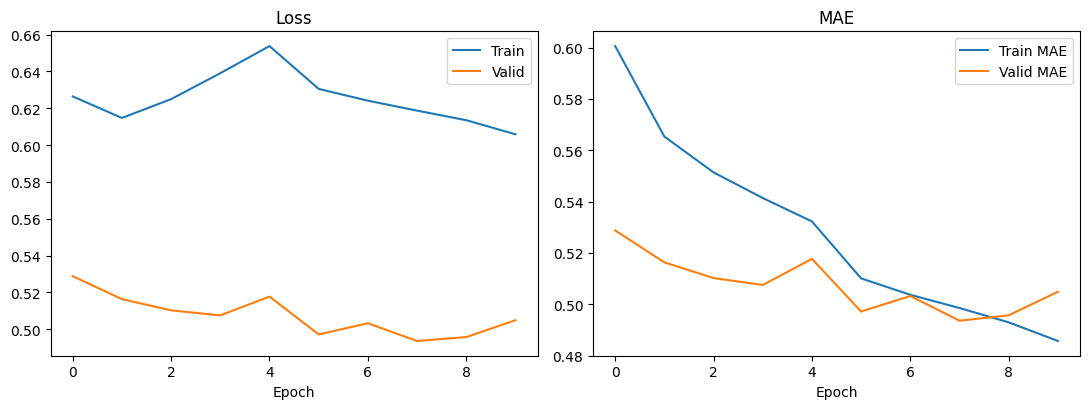

In [28]:
# =========================
# Train loop (REGRESSION, with AMP, warmup for contrastive)
# =========================

import os, random, numpy as np, torch
from scipy.stats import pearsonr
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import StepLR
import matplotlib.pyplot as plt

SEED = 20250912
def set_seed(seed: int):
    os.environ["PYTHONHASHSEED"] = str(seed)
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(SEED)

# 若你有 DataLoader，请在创建 DataLoader 时加：
#   worker_init_fn=seed_worker, generator=g_loader
def seed_worker(worker_id):
    worker_seed = (torch.initial_seed() ^ (worker_id + 1)) % 2**32
    np.random.seed(worker_seed); random.seed(worker_seed)
g_loader = torch.Generator(); g_loader.manual_seed(SEED)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 超参（保留你原本风格）
TEXT_DIM, AUDIO_DIM, HIDDEN, HEADS = 768, 1024, 256, 8
DROPOUT = 0.01
LR = 1e-4; WEIGHT_DECAY = 1e-2
STEP_SIZE = 5; GAMMA = 0.3
EPOCHS = 10
PATIENCE = 5
CKPT_PATH = 'reg-textaudio_supcon_best.' + str(SEED) +'pth'

# 对比学习的权重（warmup 到目标权重）
CONTRASTIVE_TARGET = 0.05
CONTRASTIVE_WARMUP_EPOCHS = 5
SAME_UTTER_WEIGHT = 2.0
TEMP = 0.07
GRAD_CLIP = 1.0

# —— 构建模型（你已把头换成回归头）
model = TextAudioCrossAttentionClassifier(
    text_dim=TEXT_DIM, audio_dim=AUDIO_DIM, hidden_dim=HIDDEN, num_heads=HEADS,
    dropout_rate=DROPOUT, proj_dim=128, modality_dropout_p=0.15,
    temperature=TEMP, same_utter_weight=SAME_UTTER_WEIGHT
).to(device)

# 损失函数：回归 → MAE（与评估指标一致）
criterion_reg = nn.L1Loss()   # (= MAE)；若想用 MSE：nn.MSELoss()

optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

USE_AMP = torch.cuda.is_available()
scaler = torch.cuda.amp.GradScaler(enabled=USE_AMP)

best_val_mae, bad_epochs = float('inf'), 0
train_losses, valid_losses = [], []
train_maes, valid_maes = [], []
train_corrs, valid_corrs = [], []

for epoch in range(EPOCHS):
    # ---- Train ----
    model.train()
    total_loss = 0.0
    total_count = 0
    abs_err_sum = 0.0
    all_pred, all_true = [], []

    progress = min(1.0, (epoch + 1) / max(1, CONTRASTIVE_WARMUP_EPOCHS))
    contrastive_weight = CONTRASTIVE_TARGET * progress

    for batch in train_loader:
        if len(batch) >= 3:
            text_features, audio_features, labels = batch[:3]
        else:
            text_features, audio_features, labels = batch
        text_features = text_features.to(device)
        audio_features = audio_features.to(device)
        labels = labels.to(device)               # [B] float

        optimizer.zero_grad(set_to_none=True)
        with torch.cuda.amp.autocast(enabled=USE_AMP):
            # 传入连续标签：启用连续版 SupCon；不想用对比可传 None
            y_hat, c_loss = model(text_features, audio_features, labels=labels)
            reg_loss = criterion_reg(y_hat, labels)
            loss = reg_loss + contrastive_weight * c_loss

        scaler.scale(loss).backward()
        if GRAD_CLIP is not None:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)
        scaler.step(optimizer)
        scaler.update()

        bs = labels.size(0)
        total_loss   += loss.item() * bs
        abs_err_sum  += torch.abs(y_hat.detach() - labels).sum().item()
        total_count  += bs
        all_pred.extend(y_hat.detach().cpu().tolist())
        all_true.extend(labels.detach().cpu().tolist())

    train_loss = total_loss / max(1, total_count)
    train_mae  = abs_err_sum / max(1, total_count)
    try:
        train_corr = pearsonr(all_pred, all_true)[0]
    except Exception:
        train_corr = 0.0

    train_losses.append(train_loss)
    train_maes.append(train_mae)
    train_corrs.append(train_corr)
    scheduler.step()

    # ---- Valid ----
    model.eval()
    v_total_loss = 0.0
    v_abs_err_sum = 0.0
    v_count = 0
    v_pred, v_true = [], []
    with torch.no_grad():
        for batch in valid_loader:
            if len(batch) >= 3:
                text_features, audio_features, labels = batch[:3]
            else:
                text_features, audio_features, labels = batch
            text_features = text_features.to(device)
            audio_features = audio_features.to(device)
            labels = labels.to(device)

            with torch.cuda.amp.autocast(enabled=USE_AMP):
                # 验证阶段可传 labels=None（只做前向，不影响 c_loss），也可传 labels 用连续 SupCon
                y_hat, c_loss = model(text_features, audio_features, labels=None)
                reg_loss = criterion_reg(y_hat, labels)
                loss = reg_loss  # 验证不叠加对比学习，避免噪声

            bs = labels.size(0)
            v_total_loss += loss.item() * bs
            v_abs_err_sum += torch.abs(y_hat - labels).sum().item()
            v_count += bs
            v_pred.extend(y_hat.detach().cpu().tolist())
            v_true.extend(labels.detach().cpu().tolist())

    valid_loss = v_total_loss / max(1, v_count)
    valid_mae  = v_abs_err_sum / max(1, v_count)
    try:
        valid_corr = pearsonr(v_pred, v_true)[0]
    except Exception:
        valid_corr = 0.0

    valid_losses.append(valid_loss)
    valid_maes.append(valid_mae)
    valid_corrs.append(valid_corr)

    print(f"Epoch {epoch+1:02d} | "
          f"TrainLoss {train_loss:.4f} MAE {train_mae:.4f} Corr {train_corr:.4f} | "
          f"ValLoss {valid_loss:.4f} MAE {valid_mae:.4f} Corr {valid_corr:.4f} | "
          f"w_contrast {contrastive_weight:.3f}")

    # 以 Val MAE 最小作为 early stopping/best
    if valid_mae < best_val_mae - 1e-6:
        best_val_mae = valid_mae; bad_epochs = 0
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'random_seed': SEED,
            'config': {
                'TEMP': TEMP, 'SAME_UTTER_WEIGHT': SAME_UTTER_WEIGHT,
                'CONTRASTIVE_TARGET': CONTRASTIVE_TARGET,
                'CONTRASTIVE_WARMUP_EPOCHS': CONTRASTIVE_WARMUP_EPOCHS,
                'USE_AMP': USE_AMP
            }
        }, CKPT_PATH)
        print(f"  ✅ New best saved to {CKPT_PATH} (Val MAE={best_val_mae:.4f})")
    else:
        bad_epochs += 1
        if bad_epochs >= PATIENCE:
            print("  ⏹️ Early stopping triggered.")
            break

print(f"[Done] Best Val MAE: {best_val_mae:.4f}")

# ---- Plot curves ----
plt.figure(figsize=(11,4.2))
plt.subplot(1,2,1); plt.plot(train_losses, label='Train'); plt.plot(valid_losses, label='Valid'); plt.title('Loss'); plt.xlabel('Epoch'); plt.legend()
plt.subplot(1,2,2); plt.plot(train_maes, label='Train MAE'); plt.plot(valid_maes, label='Valid MAE'); plt.title('MAE'); plt.xlabel('Epoch'); plt.legend()
plt.tight_layout(); plt.show()


In [29]:
# =========================
# Test (REGRESSION metrics)
# =========================
from scipy.stats import pearsonr
import numpy as np
import torch

def _strip_module_prefix(sd: dict):
    return { (k[7:] if k.startswith('module.') else k): v for k, v in sd.items() }

def load_state_flex(model, ckpt_path, device):
    ckpt = torch.load(ckpt_path, map_location=device)
    if isinstance(ckpt, dict) and ('model_state_dict' in ckpt or 'state_dict' in ckpt):
        sd = ckpt.get('model_state_dict', ckpt.get('state_dict'))
    else:
        sd = ckpt
    sd = _strip_module_prefix(sd)
    missing, unexpected = model.load_state_dict(sd, strict=False)
    if missing:
        print('[eval/load] Missing keys (show up to 8):', list(missing)[:8])
    if unexpected:
        print('[eval/load] Unexpected keys (show up to 8):', list(unexpected)[:8])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
USE_AMP = torch.cuda.is_available()

model = TextAudioCrossAttentionClassifier(
    text_dim=TEXT_DIM, audio_dim=AUDIO_DIM, hidden_dim=HIDDEN, num_heads=HEADS,
    dropout_rate=DROPOUT, proj_dim=128, modality_dropout_p=0.15,
    temperature=TEMP, same_utter_weight=SAME_UTTER_WEIGHT
).to(device)

best_model_path = CKPT_PATH  # 用训练时保存的
load_state_flex(model, best_model_path, device)
model.eval()

all_pred, all_true = [], []
with torch.no_grad():
    for text_features, audio_features, labels in test_loader:
        text_features = text_features.to(device)
        audio_features = audio_features.to(device)
        labels = labels.to(device)

        with torch.cuda.amp.autocast(enabled=USE_AMP):
            # 测试不需要对比损失，labels=None
            y_hat, _ = model(text_features, audio_features, labels=None)

        all_pred.extend(y_hat.detach().cpu().tolist())
        all_true.extend(labels.detach().cpu().tolist())

all_pred = np.array(all_pred, dtype=np.float32)
all_true = np.array(all_true, dtype=np.float32)

mae  = np.mean(np.abs(all_pred - all_true))
try:
    corr = pearsonr(all_pred, all_true)[0]
except Exception:
    corr = 0.0

print(f"[TEST] MAE: {mae:.4f} | Pearson: {corr:.4f}")


[TEST] MAE: 0.5148 | Pearson: 0.7786


注：我们的回归任务与分类任务有个明显的不同，回归任务的valid过程中关闭了对比学习，而分类任务的valid是包含对比学习的。但因为我们的早停策略都不用loss指标，所以这点没有统一，分类代码的旧版仍然可用。